In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

In [0]:
df_payment = spark.read.format("delta").load("/mnt/gold/dim_payment")
df_user = spark.read.format("delta").load("/mnt/gold/dim_user")
df_location = spark.read.format("delta").load("/mnt/gold/dim_location")
df_calender = spark.read.format("delta").load("/mnt/gold/dim_calendar")
df_fact_request = spark.read.format("delta").load("/mnt/gold/fct_request")

In [0]:
df_payment = df_payment.toPandas()
df_user = df_user.toPandas()
df_location = df_location.toPandas()
df_calender = df_calender.toPandas()
df_fact_request = df_fact_request.toPandas()

/databricks/spark/python/pyspark/sql/pandas/utils.py:109: UserWarning: The conversion of DecimalType columns is inefficient and may take a long time. Column names: [latitude, longitude] If those columns are not necessary, you may consider dropping them or converting to primitive types before the conversion.
  warnings.warn(
/databricks/spark/python/pyspark/sql/pandas/utils.py:109: UserWarning: The conversion of DecimalType columns is inefficient and may take a long time. Column names: [trip_distance, base_fare, extra_fare, mta_tax, tip_amount, tolls_amount, improvement_surcharge] If those columns are not necessary, you may consider dropping them or converting to primitive types before the conversion.
  warnings.warn(


In [0]:
df_payment.head(20)

,s_payment,payment_method_id,method_name,payment_status_id,status_name,processing_date,record_hash
0,0,1,Apple Pay,1,Completed,2024-10-16 13:52:45,5feceb66ffc86f38d952786c6d696c79c2dbc239dd4e91...
1,1,1,Apple Pay,2,Failed,2024-10-16 13:52:45,6b86b273ff34fce19d6b804eff5a3f5747ada4eaa22f1d...
2,2,1,Apple Pay,3,Pending,2024-10-16 13:52:45,d4735e3a265e16eee03f59718b9b5d03019c07d8b6c51f...
3,3,1,Apple Pay,4,Refunded,2024-10-16 13:52:45,4e07408562bedb8b60ce05c1decfe3ad16b72230967de0...
4,4,2,Cash,1,Completed,2024-10-16 13:52:45,4b227777d4dd1fc61c6f884f48641d02b4d121d3fd328c...
5,5,2,Cash,2,Failed,2024-10-16 13:52:45,ef2d127de37b942baad06145e54b0c619a1f22327b2ebb...
6,6,2,Cash,3,Pending,2024-10-16 13:52:45,e7f6c011776e8db7cd330b54174fd76f7d0216b612387a...
7,7,2,Cash,4,Refunded,2024-10-16 13:52:45,7902699be42c8a8e46fbbb4501726517e86b22c56a189f...
8,8,3,Credit Card,1,Completed,2024-10-16 13:52:45,2c624232cdd221771294dfbb310aca000a0df6ac8b66b6...
9,9,3,Credit Card,2,Failed,2024-10-16 13:52:45,19581e27de7ced00ff1ce50b2047e7a567c76b1cbaebab...


In [0]:
df_user.head()

,user_id,full_name,email,phone_number,vehicle_id,vehicle_make,vehicle_model,vehicle_year,vehicle_color,vehicle_license_plate,processing_date,record_hash
0,2,Aaron Adams,james82@example.com,(332) 224-7965,Passenger,Passenger,Passenger,Passenger,Passenger,Passenger,2024-10-16 13:52:25,683e6c22fa1e45bef5fbaee690690bb2aae9fbdc94db98...
1,11,Aaron Allen,nicolecasey@example.com,(921) 454-7983,Passenger,Passenger,Passenger,Passenger,Passenger,Passenger,2024-10-16 13:52:25,7296d6da075186b5bae1067a7627289bc2caeeb1485e5b...
2,14,Aaron Alvarez,daniel11@example.net,(240) 297-8660,Passenger,Passenger,Passenger,Passenger,Passenger,Passenger,2024-10-16 13:52:25,8319e9cd502576c684e7ef1d9849a73e03a63b14066bff...
3,18,Aaron Anderson,vshelton@example.com,(226) 998-6405,Passenger,Passenger,Passenger,Passenger,Passenger,Passenger,2024-10-16 13:52:25,c887cc329778e8abfc2325167bbba7d53c54013f9bc2fa...
4,30,Aaron Baker,ashley20@example.com,(639) 891-6083,Passenger,Passenger,Passenger,Passenger,Passenger,Passenger,2024-10-16 13:52:25,532256cbf9b6411ef9394a18f3eec4de51f1eec92475b3...


# The propused model aim to create dynamic pricing prediction

## DataCleaning

In [0]:
#handling the missing values
print(df_payment.isnull().sum())

s_payment            0
payment_method_id    0
method_name          0
payment_status_id    0
status_name          0
processing_date      0
record_hash          0
dtype: int64


In [0]:
df_payment.shape

(24, 7)

In [0]:
#converting the data into the suitable format
df_calender['full_date'] = pd.to_datetime(df_calender['full_date'], format='%Y-%m-%d')
df_fact_request['request_datekey'] = pd.to_datetime(df_fact_request['request_datekey'], format='%Y%m%d')

In [0]:
df_payment_info = pd.merge(df_fact_request, df_payment, how='left', left_on='s_payment', right_on='s_payment')

In [0]:
df_payment_info["method_name"].describe()

count         584875
unique             6
top       Debit Card
freq           97898
Name: method_name, dtype: object

In [0]:
print(df_payment_info.isnull().sum())

driver_id                0
passenger_id             0
pickup_location_id       0
dropoff_location_id      0
request_datekey          0
accept_datekey           0
trip_start_datekey       0
trip_end_datekey         0
s_payment                0
trip_distance            0
base_fare                0
extra_fare               0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
record_hash_x            0
payment_method_id        0
method_name              0
payment_status_id        0
status_name              0
processing_date          0
record_hash_y            0
dtype: int64


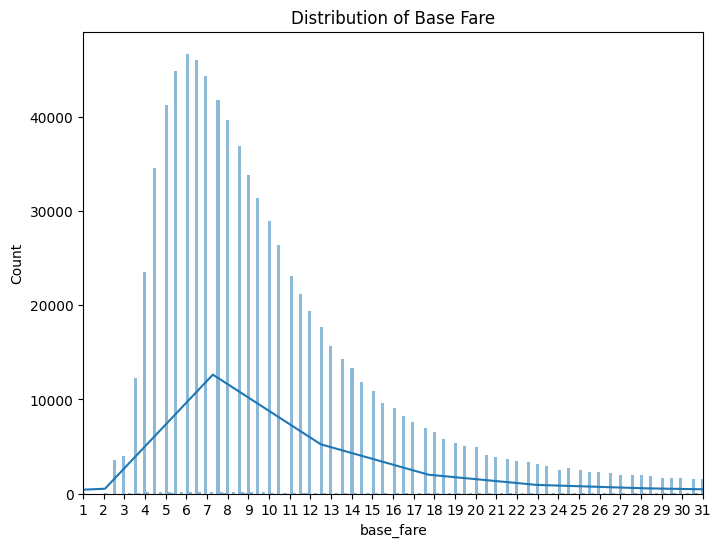

In [0]:
plt.figure(figsize=(8, 6))

# Create the histogram with a kernel density estimate (KDE)
ax = sns.histplot(df_payment_info['base_fare'], kde=True)

# Set x-axis limits and ticks
ax.set_xlim(1, 31)  # Limit the x-axis from 1 to 31
ax.set_xticks(range(1, 32))  # Set the x-ticks from 1 to 31

# Set the title of the plot
plt.title('Distribution of Base Fare')

# Show the plot
plt.show()

In [0]:
driver_data = df_user[df_user['vehicle_model'] != 'Passenger']
driver_data.head()

,user_id,full_name,email,phone_number,vehicle_id,vehicle_make,vehicle_model,vehicle_year,vehicle_color,vehicle_license_plate,processing_date,record_hash
72944,700005,Aaron Adams,dbowen@example.net,(672) 995-6696,75956,Ford,Escape,1996,Brown,3G783,2024-10-16 13:52:25,95bcf56ae7d7d1a858c80a6bf5790a4e21fdefcf178093...
72945,700009,Aaron Adkins,jchan@example.com,(959) 936-7702,194019,Kia,Optima,2005,Blue,VJP4675,2024-10-16 13:52:25,64243d430f017b27b3497ea0cd2129730ccdbe1447817f...
72946,700018,Aaron Ali,zhughes@example.com,(614) 514-6952,348707,Volkswagen,Golf,2016,Yellow,3PL6905,2024-10-16 13:52:25,b33857b64a5b8b5343f1e1a3e00fd12d0a72de350b7883...
72947,700030,Aaron Anderson,amedina@example.com,(978) 122-8849,91393,Ford,F-150,1991,Gray,82-10322,2024-10-16 13:52:25,a3e91d7b8549f8cdf35e437878bd7b5b4495ab1dd2bc55...
72948,700034,Aaron Anderson,tmerritt@example.com,(794) 577-2841,220367,Kia,Sportage,2003,Silver,14GC999,2024-10-16 13:52:25,d75088f1ecee9356d897f1d90332a76119765476386900...


In [0]:
data = pd.merge(df_fact_request, driver_data, how='left', left_on='driver_id', right_on='user_id')
data["vehicle_make"].isnull().sum()

0

## Train-Split-Data

In [0]:
# Example: Removing data points that are more than 3 standard deviations away from the mean
z_scores = np.abs(stats.zscore(data[['trip_distance', 'base_fare']]))
data = data[(z_scores < 3)]

In [0]:
X = data[["trip_distance"]]
y = data['base_fare']

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [0]:
X_train.shape

(467900, 1)

In [0]:
data.shape

(584875, 29)

In [0]:
y_train.shape

(467900,)

In [0]:
y_test.isnull().count()

116975

In [0]:
X_train = X_train.fillna(X_train.mean())
y_train = y_train.fillna(y_train.mean())

# Impute missing values in the testing set
X_test = X_test.fillna(X_test.mean())
y_test = y_test.fillna(y_test.mean())

In [0]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [0]:
base_fare_pred = model.predict(X_test)

In [0]:
# Calculate performance metrics
mse = mean_squared_error(y_test, base_fare_pred)
rmse = mse ** 0.5

print(f'Root Mean Squared Error: {rmse}')

# Optional: Check model coefficients
coefficients = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': model.coef_})
print(coefficients)

Root Mean Squared Error: 5.077542201133626
         Feature  Coefficient
0  trip_distance     1.206235


In [0]:
data["trip_distance"].max()

Decimal('181.40')

In [0]:
data["trip_distance"].min()

Decimal('0.00')

In [0]:
data["base_fare"].min()

Decimal('-16.30')

In [0]:
data["base_fare"].max()

Decimal('42.20')

In [0]:
import pickle

In [0]:
pickle.dump(model, open("model.pkl", "wb"))